
   📊 학습 붕괴 원인 분석: 단계별 성능 추이

✅ [핵심 증거] SSL 사전학습 성능 회복 추이 (Linear Eval 정확도) 그래프:


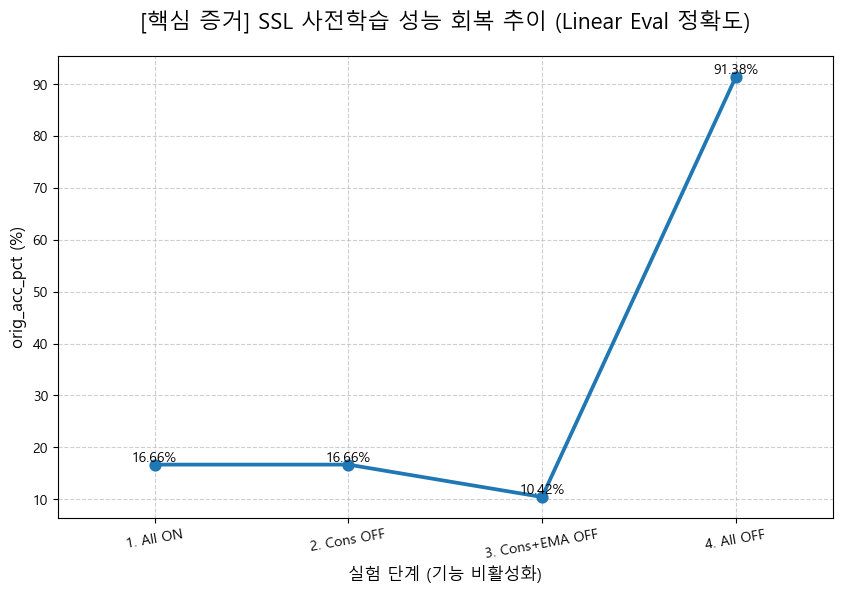


✅ SSL Fine-Tune 최고 성능 회복 추이 그래프:


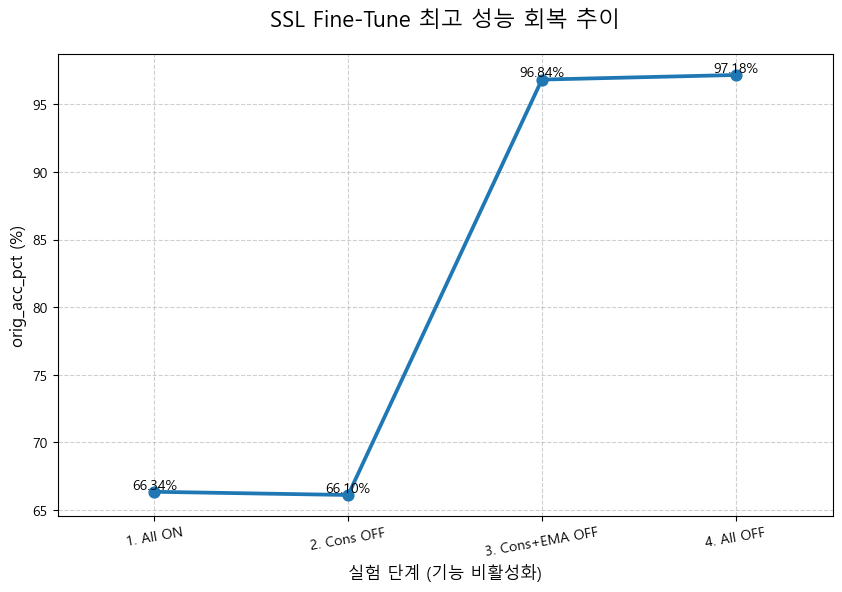


✅ Supervised 모델 안정성(Retention) 변화 추이 그래프:


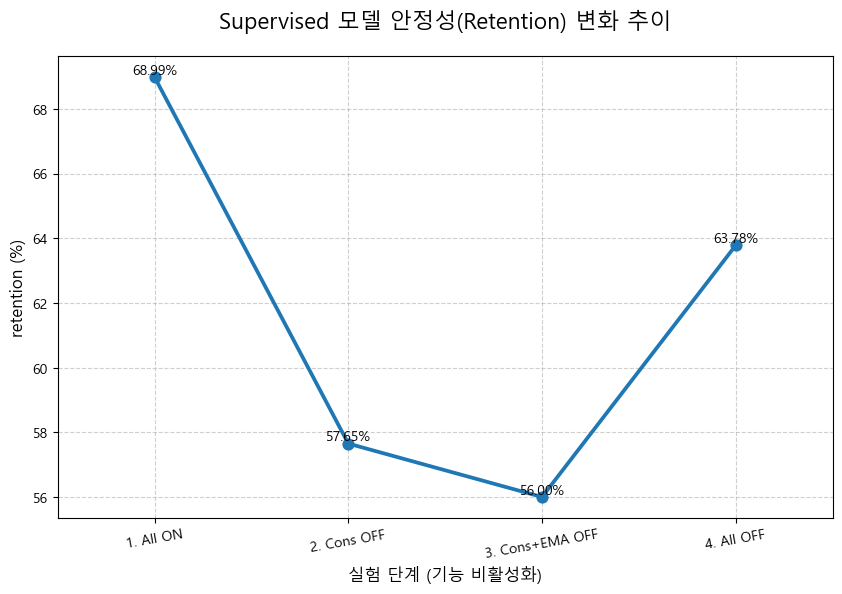


   📊 전체 실험 결과 종합 비교

✅ 전체 실험 최고 정확도(Orig Acc) 종합 비교 그래프:


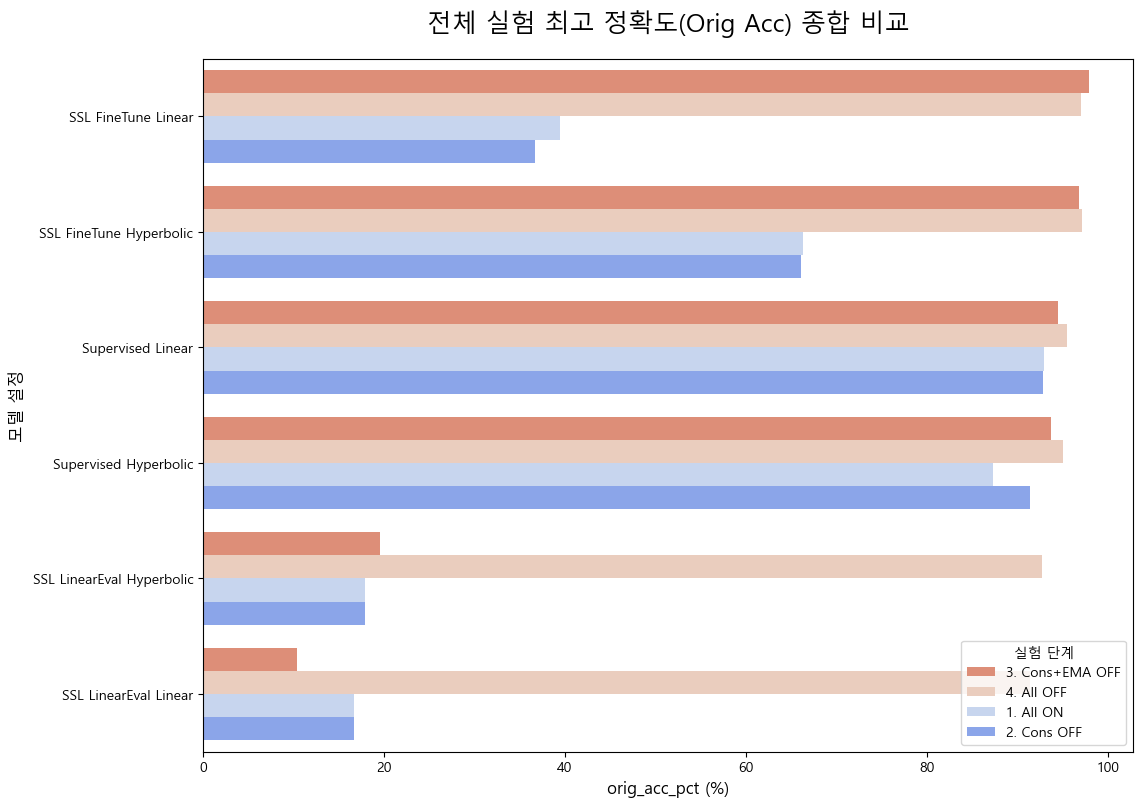


✅ 전체 실험 안정성(Retention) 종합 비교 그래프:


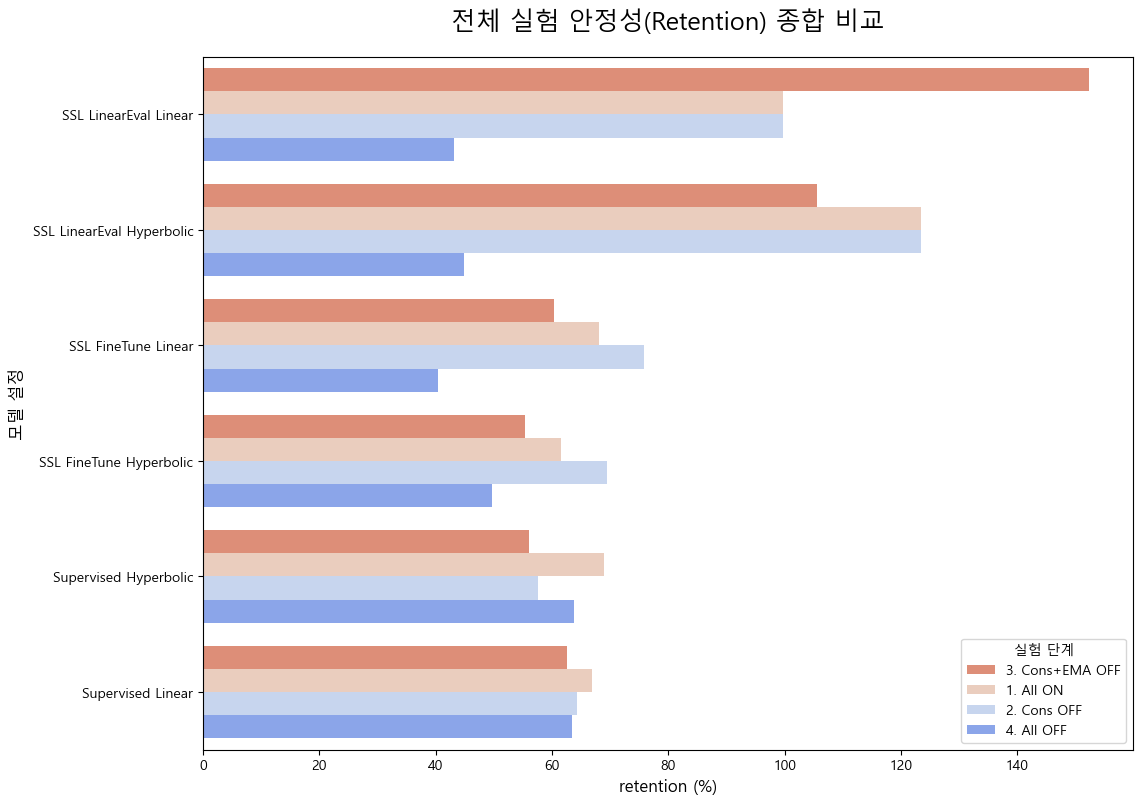


모든 비교 시각화가 완료되었습니다.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

def setup_korean_font():
    """
    한글 폰트를 설정합니다. Windows, Mac 환경에 맞게 폰트를 지정해주세요.
    """
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except RuntimeError:
        print("경고: 'Malgun Gothic' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    plt.rcParams['axes.unicode_minus'] = False

def load_and_process_data(file_config):
    """
    여러 JSON 파일을 불러와 'experiment_tag'를 붙여 하나의 DataFrame으로 통합합니다.
    """
    all_data = []
    for tag, filepath in file_config.items():
        if not os.path.exists(filepath):
            print(f"경고: 파일을 찾을 수 없습니다 - {filepath}")
            continue
        
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        for item in data:
            item['experiment_tag'] = tag
        all_data.extend(data)

    if not all_data:
        print("오류: 시각화할 데이터를 불러오지 못했습니다. 파일 경로를 확인해주세요.")
        return None, None

    df = pd.DataFrame(all_data)
    
    # 데이터 전처리
    df['orig_acc_pct'] = df['orig_acc'] * 100
    df['group'] = df.apply(
        lambda row: f"SSL-{row['mode'].replace('_', ' ').title()}" if row['method'] == 'ssl' else 'Supervised',
        axis=1
    )
    df['config_readable'] = df['config'].str.replace('_', ' ')

    # 시나리오별 상세 데이터 생성
    scenario_records = []
    for _, record in df.iterrows():
        for scenario_result in record.get('transition_results', []):
            scenario_label = f"S{scenario_result.get('scenario', 'N/A')}"
            if 'class_A' in scenario_result and 'class_B' in scenario_result:
                 scenario_label += f": {scenario_result['class_A']}↔{scenario_result['class_B']}"

            new_record = {
                'experiment_tag': record['experiment_tag'],
                'config': record['config'],
                'group': record['group'],
                'scenario_label': scenario_label,
                'level': scenario_result.get('level', 'Unknown'),
                'scenario_retention': (1 - scenario_result.get('class_drop', 0) / record['orig_acc']) * 100 if record.get('orig_acc', 0) > 0 else 0
            }
            scenario_records.append(new_record)
            
    scenario_df = pd.DataFrame(scenario_records)
    
    return df, scenario_df

def visualize_performance_trend(df, model_config, metric, title):
    """실험 단계별 성능 변화 추이를 라인 플롯으로 시각화합니다."""
    plot_data = df[df['config'] == model_config].copy()
    
    # 실험 순서 정의
    experiment_order = ['1. All ON', '2. Cons OFF', '3. Cons+EMA OFF', '4. All OFF']
    plot_data['experiment_tag'] = pd.Categorical(plot_data['experiment_tag'], categories=experiment_order, ordered=True)
    plot_data = plot_data.sort_values('experiment_tag')
    
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='experiment_tag', y=metric, data=plot_data, markers='o', linestyles='-')
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('실험 단계 (기능 비활성화)', fontsize=12)
    plt.ylabel(f'{metric} (%)', fontsize=12)
    plt.xticks(rotation=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 값 표시
    for index, row in plot_data.iterrows():
        plt.text(row['experiment_tag'], row[metric], f"{row[metric]:.2f}%", ha='center', va='bottom', fontsize=10)
        
    print(f"\n✅ {title} 그래프:")
    plt.show()

def visualize_grouped_barchart(df, metric, title):
    """실험별로 그룹화된 막대그래프를 생성합니다."""
    plt.figure(figsize=(12, 9))
    
    sns.barplot(
        y='config_readable',
        x=metric,
        hue='experiment_tag',
        data=df.sort_values(metric, ascending=False),
        palette='coolwarm_r'
    )
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel(f'{metric} (%)', fontsize=12)
    plt.ylabel('모델 설정', fontsize=12)
    plt.legend(title='실험 단계')
    
    print(f"\n✅ {title} 그래프:")
    plt.show()


def main():
    """메인 실행 함수"""
    # --- 설정 ---
    JSON_FILE_CONFIG = {
        '1. All ON': 'C://Users/park9/HAR/SSL_HAR/RESULTS/IMPROVE/ALL/all_supervised_vs_ssl_results_optimized.json',
        '2. Cons OFF': 'C://Users/park9/HAR/SSL_HAR/RESULTS/IMPROVE/consOFF/consOFF_supervised_vs_ssl_results_optimized.json',
        '3. Cons+EMA OFF': 'C://Users/park9/HAR/SSL_HAR/RESULTS/IMPROVE/cons+emaOFF/cons+emaOFF_supervised_vs_ssl_results_optimized.json',
        '4. All OFF': 'C://Users/park9/HAR/SSL_HAR/RESULTS/IMPROVE/cons+ema+CosOFF/cons+ema+CosOFF_supervised_vs_ssl_results_optimized.json'
    }
    
    setup_korean_font()
    
    # 데이터 로드 및 통합
    main_df, scenario_df = load_and_process_data(JSON_FILE_CONFIG)
    
    if main_df is not None:
        # --- 시각화 실행 ---
        print("\n" + "="*80)
        print("   📊 학습 붕괴 원인 분석: 단계별 성능 추이")
        print("="*80)
        
        # 1. SSL 사전학습이 언제 살아났는가?
        visualize_performance_trend(
            main_df, 
            model_config='SSL_LinearEval_Linear', 
            metric='orig_acc_pct', 
            title='[핵심 증거] SSL 사전학습 성능 회복 추이 (Linear Eval 정확도)'
        )
        
        # 2. SSL Fine-Tune 성능은 어떻게 변했는가?
        visualize_performance_trend(
            main_df,
            model_config='SSL_FineTune_Hyperbolic',
            metric='orig_acc_pct',
            title='SSL Fine-Tune 최고 성능 회복 추이'
        )
        
        # 3. Supervised 모델의 안정성은 어떻게 변했는가?
        visualize_performance_trend(
            main_df,
            model_config='Supervised_Hyperbolic',
            metric='retention',
            title='Supervised 모델 안정성(Retention) 변화 추이'
        )

        print("\n" + "="*80)
        print("   📊 전체 실험 결과 종합 비교")
        print("="*80)

        # 4. 전체 실험 최고 정확도 비교
        visualize_grouped_barchart(
            main_df, 
            'orig_acc_pct', 
            '전체 실험 최고 정확도(Orig Acc) 종합 비교'
        )

        # 5. 전체 실험 안정성 비교
        visualize_grouped_barchart(
            main_df, 
            'retention', 
            '전체 실험 안정성(Retention) 종합 비교'
        )
        
        print("\n모든 비교 시각화가 완료되었습니다.")

if __name__ == '__main__':
    main()
